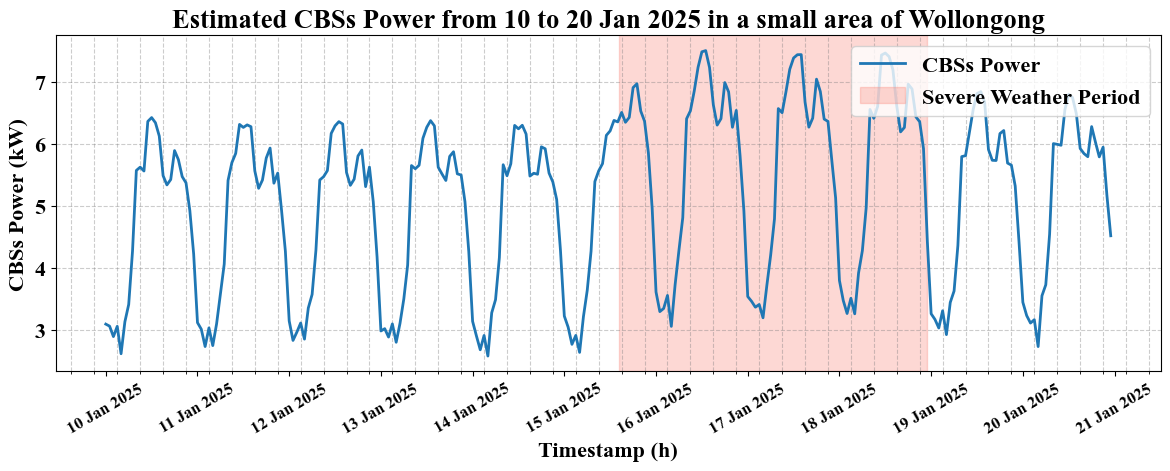

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Configuration:
#   - 1 × 5G Macro BS: up to 4 kW
#   - 4 × 5G Micro BS: each between 0.2 – 1.5 kW
# Total area capacity: 7.5 kW

# 1) Define the 24-hour baseline “multi-BS” profile (in kW) and scale it to a 7.5 kW peak.
pattern_24h = np.array([
    150, 140, 135, 145, 130, 155, 170, 200, 267, 268, 275, 300,
    305, 310, 300, 269, 260, 261, 285, 280, 262, 264, 240, 205
], dtype=float)
baseline_24h = (pattern_24h / pattern_24h.max()) * 7.5 # 24 values, peak exactly 7.5

# 2) Build a full hourly index from 2025-01-10 00:00 → 2025-01-20 23:00 (264 hours)
start = pd.Timestamp("2025-01-10 00:00")
end   = pd.Timestamp("2025-01-20 23:00")
rng = pd.date_range(start, end, freq="h")  # 11 days × 24 = 264 rows

# 3) Tile that 24-hour baseline for each of the 11 days
n_days    = len(rng) // 24  # should be 11
full_base = np.tile(baseline_24h, n_days)   # length = 264

# 4) Create a DataFrame with every hour and its baseline power
df = pd.DataFrame({
    "Timestamp":   rng,
    "Baseline_kW": full_base
})

# 5) Merge precipitation (fill missing with 0% rain)
weather_file = "Data/Exp/ProcessedData_Wollongong_Weather__10_20_Jan_2025.csv"
df_weather   = pd.read_csv(weather_file, parse_dates=["Timestamp"])
df = pd.merge(
    df,
    df_weather[["Timestamp", "Precipitation_%"]],
    on="Timestamp",
    how="left"
)
df["Precipitation_%"] = df["Precipitation_%"].fillna(0.0)

# Immediately scale baseline by precipitation reduction
df['CBSs_kW'] = df['Baseline_kW'] * (1.0 - df['Precipitation_%'] / 100.0)

# 6) Define the severe-weather window and pre/after masks
SEVERE_START    = pd.Timestamp("2025-01-15 14:20")
SEVERE_END      = pd.Timestamp("2025-01-18 22:59")
mask_pre        = df["Timestamp"] < SEVERE_START
mask_severe     = (df["Timestamp"] >= SEVERE_START) & (df["Timestamp"] <= SEVERE_END)
mask_post       = df["Timestamp"] > SEVERE_END

# 7) Choose constant multipliers for pre/severe/post periods
FACTOR_PRE    = 0.85  # scale before storm
FACTOR_SEVERE = 1.00  # scale during storm
FACTOR_POST   = 0.90  # scale after storm

# 8) Generate random noise between -1 and +2 kW for each hour
np.random.seed(42)  # optional: for reproducibility
noise = np.random.uniform(-0.10, 0.20, size=len(df))

# 9) Apply those multipliers + noise to compute final CBSs_kW
df["CBSs_kW"] = 0.0
df.loc[mask_pre,    "CBSs_kW"] = df.loc[mask_pre,    "Baseline_kW"] * FACTOR_PRE + noise[mask_pre]
df.loc[mask_severe, "CBSs_kW"] = df.loc[mask_severe, "Baseline_kW"] * FACTOR_SEVERE + noise[mask_severe]
df.loc[mask_post,   "CBSs_kW"] = df.loc[mask_post,   "Baseline_kW"] * FACTOR_POST + noise[mask_post]

# 10) Clip to the hardware limit [0, 7.5 kW]
df["CBSs_kW"] = df["CBSs_kW"].clip(lower=0.0, upper=7.5)

df["CBSs_kWh"] = df["CBSs_kW"].multiply(60)

# 11) Save only Timestamp + CBSs_kW to CSV
df = df[["Timestamp", "CBSs_kW", "CBSs_kWh"]].copy()
df.to_csv(
    "Data/Test/PowerDemand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv",
    index=False
)

# 12) Plot the final curve, shading the severe-weather window
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"]   = 16
plt.rcParams["font.weight"] = "bold"

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    df["Timestamp"],
    df["CBSs_kW"],
    color="tab:blue",
    linewidth=2,
    label="CBSs Power"
)

ax.axvspan(
    SEVERE_START,
    SEVERE_END,
    color="salmon",
    alpha=0.3,
    label="Severe Weather Period"
)

# X-axis: one major tick per day, minor tick every 6 hours
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

ax.grid(which="minor", linestyle="--", color="gray", alpha=0.4)
ax.grid(which="major", axis="y", linestyle="--", color="gray", alpha=0.4)
ax.grid(which="major", axis="x", visible=False)

ax.set_xlabel("Timestamp (h)", fontweight="bold")
ax.set_ylabel("CBSs Power (kW)", fontweight="bold")
ax.set_title(
    "Estimated CBSs Power from 10 to 20 Jan 2025 in a small area of Wollongong",
    fontweight="bold"
)

ax.tick_params(axis="x", rotation=30, labelsize=12)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd

# Assume df already has:
#    • Timestamp (dtype datetime64[ns])
#    • CBSs_kW   (float, instantaneous maximum kW at each hour)

# 1) Ensure the DataFrame is sorted by Timestamp
df = df.sort_values("Timestamp")

# 2) Extract the calendar date from each timestamp
df["Date"] = df["Timestamp"].dt.date

# 3) For each date, sum the 24 instantaneous kW readings and then multiply by 60
#    so that each “instantaneous kW” is treated as if it persisted for 60 minutes.
#    The result is in units of kW·minutes (i.e., total kW-minutes per day).
daily_totals = (
    df
    .groupby("Date", as_index=False)["CBSs_kW"]
    .sum()                # sum of 24 instantaneous kW values
    .assign(Total_kWmin=lambda x: x["CBSs_kW"] * 60)
    .rename(columns={"CBSs_kW": "CBSs_kWh/Day"})
)

# If you prefer to call the 60×-multiplied column “Total_kWh_for_Date” (though strictly speaking
# this is kW·minutes), you can rename:
daily_totals = daily_totals.rename(columns={"Total_kWmin": "CBSs_kWmin/Day"})

print(daily_totals)

# 4) (Optional) Save to CSV
daily_totals.to_csv("Data/Exp/Daily_Power_Demand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv", index=False)

          Date  CBSs_kWh/Day  CBSs_kWmin/Day
0   2025-01-10    115.436912     6926.214698
1   2025-01-11    115.567961     6934.077683
2   2025-01-12    115.906767     6954.406004
3   2025-01-13    115.939675     6956.380498
4   2025-01-14    115.663358     6939.801476
5   2025-01-15    124.283600     7457.016015
6   2025-01-16    135.607501     8136.450063
7   2025-01-17    135.906610     8154.396623
8   2025-01-18    135.580528     8134.831652
9   2025-01-19    122.633538     7358.012258
10  2025-01-20    123.354338     7401.260296


In [16]:
import pandas as pd

# 1) Load the CSV you saved, which has columns Timestamp, CBSs_kW, CBSs_kWh
df = pd.read_csv(
    "Data/Test/PowerDemand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv",
    parse_dates=["Timestamp"]
)

# 2) Define the severe-weather window
SEVERE_START = pd.Timestamp("2025-01-15 14:20")
SEVERE_END   = pd.Timestamp("2025-01-18 22:59")

# 3) Filter rows whose Timestamp falls within [SEVERE_START, SEVERE_END]
mask = (df["Timestamp"] >= SEVERE_START) & (df["Timestamp"] <= SEVERE_END)
df_severe = df.loc[mask]

# 4) Sum the CBSs_kWh column over that interval
total_kwh_during_severe = df_severe["CBSs_kWh"].sum()

print(f"Total CBSs energy required from {SEVERE_START} to {SEVERE_END}: "
      f"{total_kwh_during_severe:.4f} kWh")

Total CBSs energy required from 2025-01-15 14:20:00 to 2025-01-18 22:59:00: 27570.1069 kWh
